In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import files

# Upload the files (you’ll get a file picker)
uploaded = files.upload()


Saving pirvision_office_dataset2.csv to pirvision_office_dataset2.csv
Saving pirvision_office_dataset1.csv to pirvision_office_dataset1.csv


In [30]:
#We first read the 2 data files
df1 = pd.read_csv('pirvision_office_dataset1.csv')
df2 = pd.read_csv('pirvision_office_dataset2.csv')

In [31]:
# #We first shuffle these 2 dataframes
# df1 = df1.sample(frac = 1, random_state=1).reset_index(drop=True)
# df2 = df2.sample(frac = 1, random_state=1).reset_index(drop=True)

#We now merge these 2 dataframes
df = pd.concat([df1, df2], ignore_index=True)

#We print the shapes of all datafmrames
print(df1.shape, df2.shape, df.shape)

#Displaying the merged dataframe
# display(df.head(100))


(7651, 59) (7651, 59) (15302, 59)


In [5]:
df[df['Label'] == 3]['Temperature_F'].value_counts()


,count
Temperature_F,
0,1142


In [5]:
!pip install imblearn

## EDA on the given dataset

Dataset Overview:
Number of samples: 15302
Number of features: 59

Missing Values:
0


<ipython-input-8-7062a277bb7b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis')


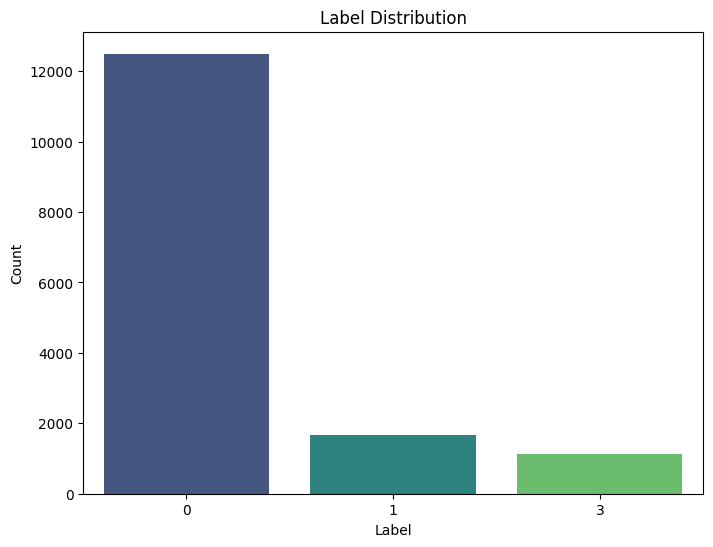


Class Distribution:
Label 0: 12494 samples (81.65%)
Label 1: 1666 samples (10.89%)
Label 3: 1142 samples (7.46%)


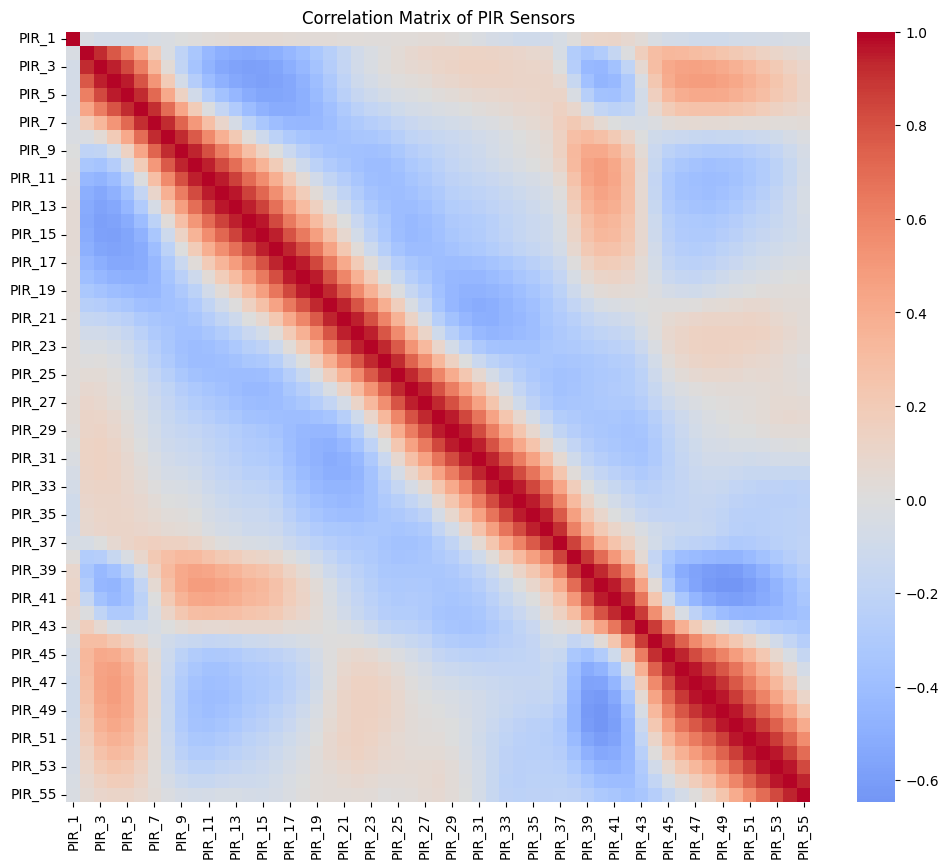

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def perform_eda(df):
    """
    Perform exploratory data analysis on the dataset.
    """
    # Dataset overview
    print("Dataset Overview:")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum().sum())

    # Label distribution visualization
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Label', data=df, palette='viridis')
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

    # Display class distribution details
    print("\nClass Distribution:")
    label_counts = df['Label'].value_counts().sort_index()
    for label, count in label_counts.items():
        print(f"Label {label}: {count} samples ({(count / len(df)) * 100:.2f}%)")

    # Correlation matrix for PIR sensors
    pir_columns = [col for col in df.columns if col.startswith('PIR_')]

    if pir_columns:
        plt.figure(figsize=(12, 10))
        correlation_matrix = df[pir_columns].corr()
        sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of PIR Sensors')
        plt.show()


# Load and analyze the dataset
perform_eda(df)


#Clearly CLASS IMBALANCE is present
1. Approach 1 : weighted loss + RNN, LSTM and GRU
2. Approach 2 : Oversampling data using SMOTE + RNN, LSTM, GRU

Later, to incorporate the numerical features
1. MLP head using the tabular feature
2. Attention included RNN and variants.

Questions
1. How to combine RNN models output with the other non time series features
2. how to make sure class imablance is resolved while using all features

#Weighted loss methods

In [32]:
df['Label'] = df['Label'].replace(3, 2)

In [7]:
print(df['Label'].unique())


[0 1 2]


In [22]:
print(df.head(10))

         Date      Time  Label  Temperature_F  PIR_1  PIR_2  PIR_3  PIR_4  \
0  2024-08-08  19:19:56      0             86  10269  10721  11156  11170   
1  2024-08-08  19:20:12      1             86  10364  10907  11299  11238   
2  2024-08-08  19:20:28      0             86  10329  10793  11197  11242   
3  2024-08-08  19:20:44      0             86  10169  10425  10822  11133   
4  2024-08-08  19:21:00      0             86  10320  10667  11104  11234   
5  2024-08-08  19:21:16      0             86  10271  10488  10944  11272   
6  2024-08-08  19:21:32      0             86  10314  10702  11132  11359   
7  2024-08-08  19:21:48      0             86  10434  10933  11237  11191   
8  2024-08-08  19:22:04      0             86  10366  10618  10973  11113   
9  2024-08-08  19:22:20      0             86  10389  10859  11208  11154   

   PIR_5  PIR_6  PIR_7  PIR_8  PIR_9  PIR_10  PIR_11  PIR_12  PIR_13  PIR_14  \
0  10931  10671  10395  10133   9885    9705    9538    9418    9469    

In [33]:
X = df.iloc[:, -55:].values.reshape(-1, 55, 1)
y = df['Label'].values

In [34]:
from sklearn.preprocessing import StandardScaler

# Step 1: Flatten the last dimension
X_reshaped = X.reshape(-1, 55)  # shape: (n_samples, 55)

# Step 2: Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Step 3: Reshape back to (n_samples, 55, 1)
X = X_scaled.reshape(-1, 55, 1)


In [35]:
import pandas as pd
import numpy as np

# Combine 'Date' and 'Time' columns into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%Y-%m-%d %H:%M:%S")

# Extract useful metadata features
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
#df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
#df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['day'] = df['datetime'].dt.day

# Optional: Encode time cyclically (recommended for hour and minute)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)


In [36]:
meta_features = [
    'hour_sin', 'hour_cos',
    'minute_sin', 'minute_cos',
    'day','Temperature_F'
]
x_meta = df[meta_features].values.astype(np.float32)


In [37]:
# prompt: display x_meta data features and standardise the values

# Standardize the metadata features
scaler = MinMaxScaler()
x_meta = scaler.fit_transform(x_meta)

# Display the standardized metadata features
print(x_meta[:10])


[[0.01703709 0.62940955 0.9567727  0.2966317  0.         0.96629214]
 [0.01703709 0.62940955 0.9330127  0.25       0.         0.96629214]
 [0.01703709 0.62940955 0.9330127  0.25       0.         0.96629214]
 [0.01703709 0.62940955 0.9330127  0.25       0.         0.96629214]
 [0.01703709 0.62940955 0.9045085  0.20610738 0.         0.96629214]
 [0.01703709 0.62940955 0.9045085  0.20610738 0.         0.96629214]
 [0.01703709 0.62940955 0.9045085  0.20610738 0.         0.96629214]
 [0.01703709 0.62940955 0.9045085  0.20610738 0.         0.96629214]
 [0.01703709 0.62940955 0.8715724  0.16543469 0.         0.96629214]
 [0.01703709 0.62940955 0.8715724  0.16543469 0.         0.96629214]]


In [28]:
print(df.head(5))

         Date      Time  Label  Temperature_F  PIR_1  PIR_2  PIR_3  PIR_4  \
0  2024-08-08  19:19:56      0             86  10269  10721  11156  11170   
1  2024-08-08  19:20:12      1             86  10364  10907  11299  11238   
2  2024-08-08  19:20:28      0             86  10329  10793  11197  11242   
3  2024-08-08  19:20:44      0             86  10169  10425  10822  11133   
4  2024-08-08  19:21:00      0             86  10320  10667  11104  11234   

   PIR_5  PIR_6  PIR_7  PIR_8  PIR_9  PIR_10  PIR_11  PIR_12  PIR_13  PIR_14  \
0  10931  10671  10395  10133   9885    9705    9538    9418    9469    9599   
1  10867  10535  10173   9950   9856    9795    9714    9702    9792    9789   
2  11052  10658  10288   9988   9819    9711    9659    9626    9726    9752   
3  11136  10834  10520  10228   9986    9848    9643    9562    9591    9618   
4  11129  10814  10453  10040   9733    9630    9578    9476    9596    9748   

   PIR_15  PIR_16  PIR_17  PIR_18  PIR_19  PIR_20  PIR_2

In [38]:
print("Original shape:", X.shape)  # Should output (15302, 1, 55)

# Create interpolation indices
original_idx = np.arange(55)  # 0-54
new_idx = np.linspace(0, 54, 109)  # 105 points between 0-54

# Initialize array for interpolated values
X_interp = np.zeros((X.shape[0], 1, 109))  # New shape: (15302, 1, 105)
print(X_interp.shape)

Original shape: (15302, 55, 1)
(15302, 1, 109)


In [39]:
X = X.reshape(-1, 1, 55)
X_interp = X_interp.reshape(-1, 1, 109)

# Verify the new shape
print(X.shape)

(15302, 1, 55)


In [40]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
from tqdm import tqdm

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Dataset Class
class PIRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Augment Data for Minority Classes (Labels 1 and 2)
def augment_data(X, y, noise_level=0.1):
    # Calculate original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print("\nOriginal Class Distribution:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(y)*100:.1f}%)")

    # Find majority class count
    majority_count = max(class_counts.values())

    X_augmented = [X.copy()]
    y_augmented = [y.copy()]

    # Augment minority classes (1 and 2)
    for cls in [1, 2]:
        if cls in class_counts:
            cls_mask = (y == cls)
            X_cls = X[cls_mask]
            current_count = class_counts[cls]

            # Calculate needed copies (minus original)
            num_copies = (majority_count // current_count) - 1
            remainder = majority_count % current_count

            # Create augmented copies
            for i in range(num_copies):
                # Alternate between noise and flipping
                if i % 2 == 0:
                    augmented = X_cls + np.random.normal(0, noise_level, X_cls.shape)
                else:
                    augmented = np.flip(X_cls, axis=1)
                X_augmented.append(augmented)
                y_augmented.append(np.full(len(X_cls), cls))

            # Add remainder with combined augmentation
            if remainder > 0:
                augmented = X_cls[:remainder] + np.random.normal(0, noise_level, X_cls[:remainder].shape)
                augmented = np.flip(augmented, axis=1)
                X_augmented.append(augmented)
                y_augmented.append(np.full(remainder, cls))

    # Combine all data
    X_combined = np.vstack(X_augmented)
    y_combined = np.hstack(y_augmented)

    # Print final distribution
    unique, counts = np.unique(y_combined, return_counts=True)
    print("\nAugmented Class Distribution:")
    total = len(y_combined)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/total*100:.1f}%)")

    return X_combined, y_combined




# LSTM Model
class PIRLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, num_classes=3, num_layers =5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Use last timestep
        return self.fc(out)

# Cross-Validation with Augmentation
def cross_validate(X, y, n_splits=5, epochs=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Augment training data with balanced classes
        X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

        # Create datasets
        train_dataset = PIRDataset(X_train_augmented, y_train_augmented)
        val_dataset = PIRDataset(X_val, y_val)

        # DataLoaders
        batch_size = 512
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Model setup
        model = PIRLSTM()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        best_f1 = 0
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate and print metrics
        print(f"\nFold {fold+1} Metrics:")
        print_metrics(all_labels, all_preds)

        # Store metrics for this fold
        fold_metrics.append({
            'macro_f1': f1_score(all_labels, all_preds, average='macro'),
            'class_metrics': {
                i: {
                    'precision': precision_score(all_labels, all_preds, labels=[i], average='micro'),
                    'recall': recall_score(all_labels, all_preds, labels=[i], average='micro'),
                    'f1': f1_score(all_labels, all_preds, labels=[i], average='micro')
                } for i in range(3)
            },
            'confusion_matrix': confusion_matrix(all_labels, all_preds)
        })

    return fold_metrics

# Print Metrics Function
def print_metrics(y_true, y_pred):
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print("Class-wise Performance:")
    for i in range(3):
        print(f"Class {i}:")
        print(f"  Precision: {precision_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  Recall: {recall_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  F1-score: {f1_score(y_true, y_pred, labels=[i], average='micro'):.4f}")

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1, 2], [0, 1, 2])
    plt.yticks([0, 1, 2], [0, 1, 2])

    for i in range(3):
        for j in range(3):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage example:
# Assuming X shape: (n_samples, sequence_length=55), y shape: (n_samples,)
# fold_results = cross_validate(X_data_array_here_as_numpy_array_, y_data_array_here_as_numpy_array_)



=== Fold 1/5 ===

Original Class Distribution:
Class 0: 9995 samples (81.7%)
Class 1: 1333 samples (10.9%)
Class 2: 913 samples (7.5%)

Augmented Class Distribution:
Class 0: 9995 samples (33.3%)
Class 1: 9995 samples (33.3%)
Class 2: 9995 samples (33.3%)

Fold 1 Metrics:
Macro F1: 0.8884
Class-wise Performance:
Class 0:
  Precision: 0.9975
  Recall: 0.9712
  F1-score: 0.9842
Class 1:
  Precision: 0.7384
  Recall: 0.9580
  F1-score: 0.8340
Class 2:
  Precision: 0.9184
  Recall: 0.7860
  F1-score: 0.8471


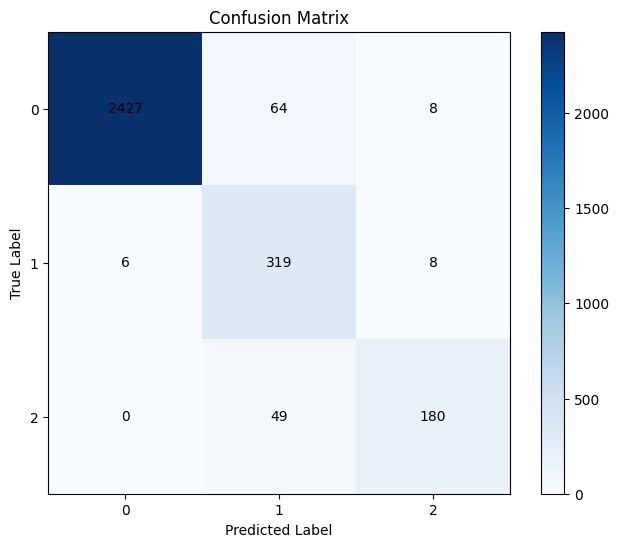


=== Fold 2/5 ===

Original Class Distribution:
Class 0: 9995 samples (81.7%)
Class 1: 1333 samples (10.9%)
Class 2: 913 samples (7.5%)

Augmented Class Distribution:
Class 0: 9995 samples (33.3%)
Class 1: 9995 samples (33.3%)
Class 2: 9995 samples (33.3%)

Fold 2 Metrics:
Macro F1: 0.8670
Class-wise Performance:
Class 0:
  Precision: 0.9996
  Recall: 0.9656
  F1-score: 0.9823
Class 1:
  Precision: 0.7119
  Recall: 0.8979
  F1-score: 0.7942
Class 2:
  Precision: 0.8282
  Recall: 0.8210
  F1-score: 0.8246


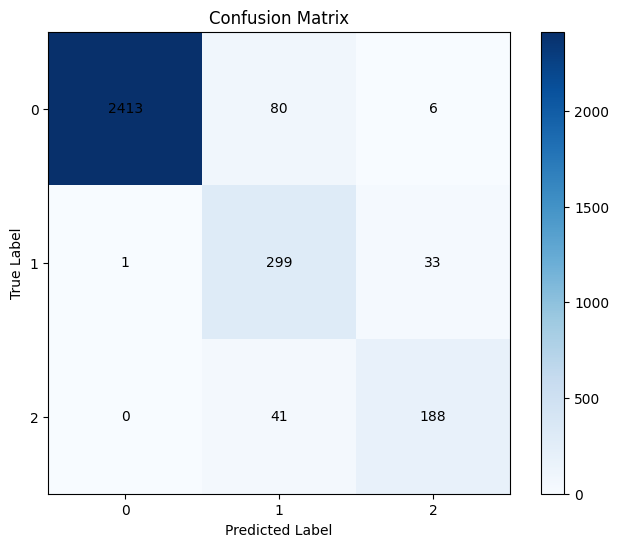


=== Fold 3/5 ===

Original Class Distribution:
Class 0: 9995 samples (81.6%)
Class 1: 1333 samples (10.9%)
Class 2: 914 samples (7.5%)

Augmented Class Distribution:
Class 0: 9995 samples (33.3%)
Class 1: 9995 samples (33.3%)
Class 2: 9995 samples (33.3%)

Fold 3 Metrics:
Macro F1: 0.9104
Class-wise Performance:
Class 0:
  Precision: 0.9972
  Recall: 0.9868
  F1-score: 0.9920
Class 1:
  Precision: 0.8196
  Recall: 0.9550
  F1-score: 0.8821
Class 2:
  Precision: 0.9196
  Recall: 0.8026
  F1-score: 0.8571


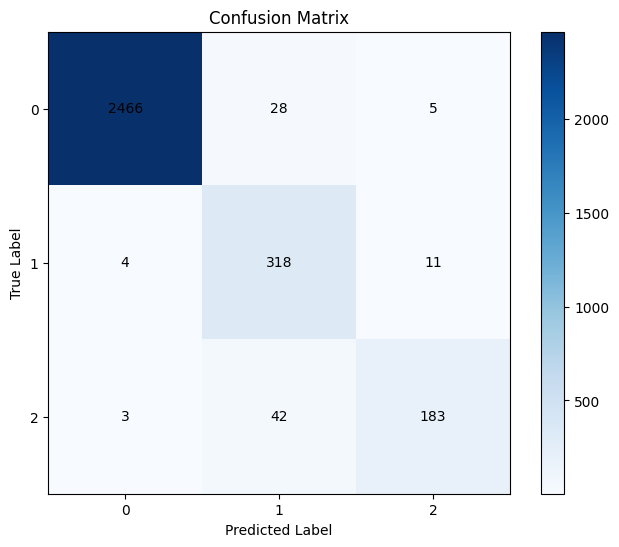


=== Fold 4/5 ===

Original Class Distribution:
Class 0: 9995 samples (81.6%)
Class 1: 1333 samples (10.9%)
Class 2: 914 samples (7.5%)

Augmented Class Distribution:
Class 0: 9995 samples (33.3%)
Class 1: 9995 samples (33.3%)
Class 2: 9995 samples (33.3%)

Fold 4 Metrics:
Macro F1: 0.9027
Class-wise Performance:
Class 0:
  Precision: 0.9948
  Recall: 0.9924
  F1-score: 0.9936
Class 1:
  Precision: 0.8420
  Recall: 0.9279
  F1-score: 0.8829
Class 2:
  Precision: 0.8900
  Recall: 0.7807
  F1-score: 0.8318


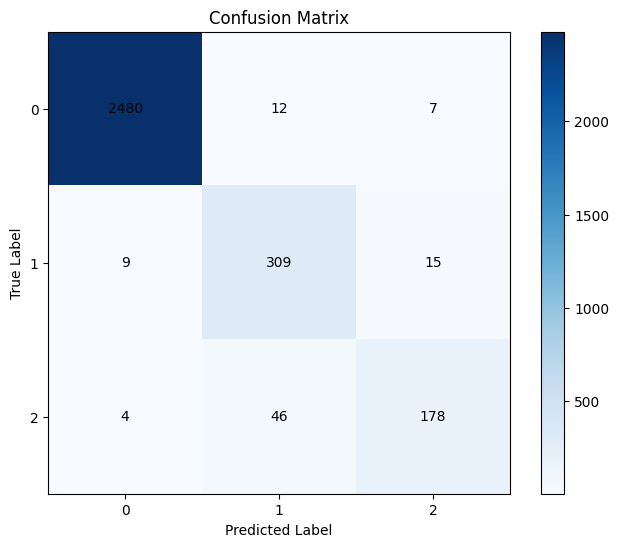


=== Fold 5/5 ===

Original Class Distribution:
Class 0: 9996 samples (81.7%)
Class 1: 1332 samples (10.9%)
Class 2: 914 samples (7.5%)

Augmented Class Distribution:
Class 0: 9996 samples (33.3%)
Class 1: 9996 samples (33.3%)
Class 2: 9996 samples (33.3%)

Fold 5 Metrics:
Macro F1: 0.8865
Class-wise Performance:
Class 0:
  Precision: 0.9967
  Recall: 0.9728
  F1-score: 0.9846
Class 1:
  Precision: 0.7435
  Recall: 0.9461
  F1-score: 0.8327
Class 2:
  Precision: 0.9086
  Recall: 0.7851
  F1-score: 0.8424


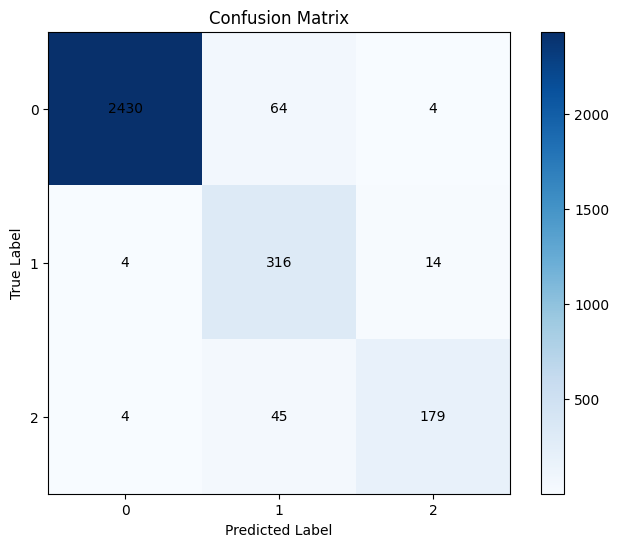

In [12]:
fold_metrics = cross_validate(X, y)


In [43]:
print(X)


[[[-0.05587524 -0.49494956 -0.55104463 ... -0.31411316 -0.37614925
   -0.26742529]]

 [[-0.05585311 -0.18063326 -0.33326959 ... -0.51321955 -0.40412321
   -0.20523098]]

 [[-0.05586127 -0.37327873 -0.48860563 ... -0.43111383 -0.34171976
   -0.40958374]]

 ...

 [[-0.05584193 -0.39524708  0.05659341 ...  0.67115557  0.69546858
    0.54776453]]

 [[-0.05577554  0.82484091  0.7677888  ... -0.08832241 -0.16526863
   -0.0519664 ]]

 [[-0.05582539  0.36012596  0.57742601 ...  0.51310205  0.32750342
    0.1212892 ]]]


In [44]:
print(y)

[0 1 0 ... 0 0 0]


In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

# using oversampling module from imblearn instead of manual augmentation
# Dataset Class


class PIRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (batch, seq_len, 1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# LSTM Model
class PIRLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, num_classes=3, num_layers =5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Use last timestep
        return self.fc(out)

# Cross-Validation with Augmentation
def cross_validate(X, y, n_splits=5, epochs=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Reshape X_train to 2D for RandomOverSampler
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, time_steps * features)

        ros = RandomOverSampler(random_state=42)
        X_train_augmented_reshaped, y_train_augmented = ros.fit_resample(X_train_reshaped, y_train)

        # Reshape X_train_augmented back to 3D
        X_train_augmented = X_train_augmented_reshaped.reshape(X_train_augmented_reshaped.shape[0], X_train.shape[1], X_train.shape[2])

        # DataLoaders
        batch_size = 512
        # DataLoaders
        train_dataset = PIRDataset(X_train_augmented, y_train_augmented)
        val_dataset = PIRDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



        # Model setup
        model = PIRLSTM()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = PIRLSTM().to(device)

        best_f1 = 0
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:

                inputs, labels = inputs.to(device), labels.to(device)
                # Check for NaN or infinite values in inputs
                if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                    print("NaN or infinite values found in inputs. Skipping batch.")
                    continue

                # Check if any label is outside the valid range
                if (labels >= model.fc.out_features).any():
                    print("Invalid label value found. Skipping batch.")
                    continue

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate and print metrics
        print(f"\nFold {fold+1} Metrics:")
        print_metrics(all_labels, all_preds)

        # Store metrics for this fold
        fold_metrics.append({
            'macro_f1': f1_score(all_labels, all_preds, average='macro'),
            'class_metrics': {
                i: {
                    'precision': precision_score(all_labels, all_preds, labels=[i], average='micro'),
                    'recall': recall_score(all_labels, all_preds, labels=[i], average='micro'),
                    'f1': f1_score(all_labels, all_preds, labels=[i], average='micro')
                } for i in range(3)
            },
            'confusion_matrix': confusion_matrix(all_labels, all_preds)
        })

    return fold_metrics

# Print Metrics Function
def print_metrics(y_true, y_pred):
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print("Class-wise Performance:")
    for i in range(3):
        print(f"Class {i}:")
        print(f"  Precision: {precision_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  Recall: {recall_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  F1-score: {f1_score(y_true, y_pred, labels=[i], average='micro'):.4f}")

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1, 2], [0, 1, 2])
    plt.yticks([0, 1, 2], [0, 1, 2])

    for i in range(3):
        for j in range(3):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage example:
# Assuming X shape: (n_samples, sequence_length=55), y shape: (n_samples,)
# fold_results = cross_validate(X_data_array_here_as_numpy_array_, y_data_array_here_as_numpy_array_)


In [45]:
X.shape

(15302, 55, 1)

In [44]:
X = X.reshape(-1, 55,1)

In [48]:
fold_metrics = cross_validate(X, y)


=== Fold 1/5 ===


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
# weighted CE loss instead of Oversampling
# weighted Focal Loss instead of Oversampling
# Dataset Class
class PIRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Augment Data for Minority Classes (Labels 1 and 2)
def augment_data(X, y, noise_level=0.1):
    # Calculate original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print("\nOriginal Class Distribution:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(y)*100:.1f}%)")

    # Find majority class count
    majority_count = max(class_counts.values())

    X_augmented = [X.copy()]
    y_augmented = [y.copy()]

    # Augment minority classes (1 and 2)
    for cls in [1, 2]:
        if cls in class_counts:
            cls_mask = (y == cls)
            X_cls = X[cls_mask]
            current_count = class_counts[cls]

            # Calculate needed copies (minus original)
            num_copies = (majority_count // current_count) - 1
            remainder = majority_count % current_count

            # Create augmented copies
            for i in range(num_copies):
                # Alternate between noise and flipping
                if i % 2 == 0:
                    augmented = X_cls + np.random.normal(0, noise_level, X_cls.shape)
                else:
                    augmented = np.flip(X_cls, axis=1)
                X_augmented.append(augmented)
                y_augmented.append(np.full(len(X_cls), cls))

            # Add remainder with combined augmentation
            if remainder > 0:
                augmented = X_cls[:remainder] + np.random.normal(0, noise_level, X_cls[:remainder].shape)
                augmented = np.flip(augmented, axis=1)
                X_augmented.append(augmented)
                y_augmented.append(np.full(remainder, cls))

    # Combine all data
    X_combined = np.vstack(X_augmented)
    y_combined = np.hstack(y_augmented)

    # Print final distribution
    unique, counts = np.unique(y_combined, return_counts=True)
    print("\nAugmented Class Distribution:")
    total = len(y_combined)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/total*100:.1f}%)")

    return X_combined, y_combined




# LSTM Model
class PIRLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, num_classes=3, num_layers =5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Use last timestep
        return self.fc(out)

# Cross-Validation with Augmentation
def cross_validate(X, y, n_splits=5, epochs=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Augment training data with balanced classes
        X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

        # Create datasets
        train_dataset = PIRDataset(X_train_augmented, y_train_augmented)
        val_dataset = PIRDataset(X_val, y_val)

        # DataLoaders
        batch_size = 512
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Model setup
        model = PIRLSTM()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        best_f1 = 0
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate and print metrics
        print(f"\nFold {fold+1} Metrics:")
        print_metrics(all_labels, all_preds)

        # Store metrics for this fold
        fold_metrics.append({
            'macro_f1': f1_score(all_labels, all_preds, average='macro'),
            'class_metrics': {
                i: {
                    'precision': precision_score(all_labels, all_preds, labels=[i], average='micro'),
                    'recall': recall_score(all_labels, all_preds, labels=[i], average='micro'),
                    'f1': f1_score(all_labels, all_preds, labels=[i], average='micro')
                } for i in range(3)
            },
            'confusion_matrix': confusion_matrix(all_labels, all_preds)
        })

    return fold_metrics

# Print Metrics Function
def print_metrics(y_true, y_pred):
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print("Class-wise Performance:")
    for i in range(3):
        print(f"Class {i}:")
        print(f"  Precision: {precision_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  Recall: {recall_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  F1-score: {f1_score(y_true, y_pred, labels=[i], average='micro'):.4f}")

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1, 2], [0, 1, 2])
    plt.yticks([0, 1, 2], [0, 1, 2])

    for i in range(3):
        for j in range(3):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage example:
# Assuming X shape: (n_samples, sequence_length=55), y shape: (n_samples,)
# fold_results = cross_validate(X_data_array_here_as_numpy_array_, y_data_array_here_as_numpy_array_)


In [ ]:
# GRU instead of LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt



# Dataset Class
class PIRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Augment Data for Minority Classes (Labels 1 and 2)
def augment_data(X, y, noise_level=0.1):
    # Calculate original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print("\nOriginal Class Distribution:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(y)*100:.1f}%)")

    # Find majority class count
    majority_count = max(class_counts.values())

    X_augmented = [X.copy()]
    y_augmented = [y.copy()]

    # Augment minority classes (1 and 2)
    for cls in [1, 2]:
        if cls in class_counts:
            cls_mask = (y == cls)
            X_cls = X[cls_mask]
            current_count = class_counts[cls]

            # Calculate needed copies (minus original)
            num_copies = (majority_count // current_count) - 1
            remainder = majority_count % current_count

            # Create augmented copies
            for i in range(num_copies):
                # Alternate between noise and flipping
                if i % 2 == 0:
                    augmented = X_cls + np.random.normal(0, noise_level, X_cls.shape)
                else:
                    augmented = np.flip(X_cls, axis=1)
                X_augmented.append(augmented)
                y_augmented.append(np.full(len(X_cls), cls))

            # Add remainder with combined augmentation
            if remainder > 0:
                augmented = X_cls[:remainder] + np.random.normal(0, noise_level, X_cls[:remainder].shape)
                augmented = np.flip(augmented, axis=1)
                X_augmented.append(augmented)
                y_augmented.append(np.full(remainder, cls))

    # Combine all data
    X_combined = np.vstack(X_augmented)
    y_combined = np.hstack(y_augmented)

    # Print final distribution
    unique, counts = np.unique(y_combined, return_counts=True)
    print("\nAugmented Class Distribution:")
    total = len(y_combined)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/total*100:.1f}%)")

    return X_combined, y_combined




# LSTM Model
class PIRLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, num_classes=3, num_layers =5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Use last timestep
        return self.fc(out)

# Cross-Validation with Augmentation
def cross_validate(X, y, n_splits=5, epochs=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Augment training data with balanced classes
        X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

        # Create datasets
        train_dataset = PIRDataset(X_train_augmented, y_train_augmented)
        val_dataset = PIRDataset(X_val, y_val)

        # DataLoaders
        batch_size = 512
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Model setup
        model = PIRLSTM()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        best_f1 = 0
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate and print metrics
        print(f"\nFold {fold+1} Metrics:")
        print_metrics(all_labels, all_preds)

        # Store metrics for this fold
        fold_metrics.append({
            'macro_f1': f1_score(all_labels, all_preds, average='macro'),
            'class_metrics': {
                i: {
                    'precision': precision_score(all_labels, all_preds, labels=[i], average='micro'),
                    'recall': recall_score(all_labels, all_preds, labels=[i], average='micro'),
                    'f1': f1_score(all_labels, all_preds, labels=[i], average='micro')
                } for i in range(3)
            },
            'confusion_matrix': confusion_matrix(all_labels, all_preds)
        })

    return fold_metrics

# Print Metrics Function
def print_metrics(y_true, y_pred):
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print("Class-wise Performance:")
    for i in range(3):
        print(f"Class {i}:")
        print(f"  Precision: {precision_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  Recall: {recall_score(y_true, y_pred, labels=[i], average='micro'):.4f}")
        print(f"  F1-score: {f1_score(y_true, y_pred, labels=[i], average='micro'):.4f}")

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1, 2], [0, 1, 2])
    plt.yticks([0, 1, 2], [0, 1, 2])

    for i in range(3):
        for j in range(3):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage example:
# Assuming X shape: (n_samples, sequence_length=55), y shape: (n_samples,)
# fold_results = cross_validate(X_data_array_here_as_numpy_array_, y_data_array_here_as_numpy_array_)
